# Healthscope case study

Problem overview as presented exactly:

One of our key business drivers is the overall value proposition of private health insurance (PHI). Fundamentally, private insurance must be good value for money. In other words, the consumer will only take up insurance if the total cost can be justified by the quality of care, condition of private facilities, accessibility of services, etc…  PHI has two primary types of coverage: Private Hospitals and “General Treatment” (ancillary coverage for dental/chiro/physio etc..). As a private hospital operator, our focus is solely on the former.

The key metric for the value proposition of PHI is % of population that has taken up insurance. As a general rule, the greater the uptake, the more buoyant the industry. Industry uptake peaked in July 2015 at 47.4% and has since experienced 16 consecutive quarters of decline to 44.2%. 

While uptake is a key metric, it does not necessarily correlate directly to hospital activity/revenue. For example, if healthy individuals are dropping coverage, the impact to total hospital episodes and benefits paid to hospitals will likely be affected less than the uptake percentage might suggest. 

----

A) [What could be causing a decrease in hospital coverage uptake **since June 2015**?](#ans_a)

B) [In that time period, what is the corresponding impact to **industry-wide private hospitals benefits and activity (both episodes & patient days)**?](#ans_b)

----

Restrictions:

* **June 2015** -> **June 2019** (16 quarters), i.e. pre-COVID

----

Aspects to investigate:

- Changes in coverage details
- Changes in population
- How much would PHs potentially profit if coverage did not decrease?

One of the more obvious impacts here is from the latter case. Intuitively, on average, the older population is more likely to claim from PHI, while the younger healthier population are not. There is a definite benefit for a the insurance provider (not hospital) to retain the population of younger adults with PHI, which can be considered a **lower-risk** buffer when it comes to overall revenue.




In [1]:
import os
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from openpyxl import load_workbook

from scipy.signal import savgol_filter


pd.options.display.width = 180
pd.options.display.max_colwidth = 120
pd.options.display.max_rows = 100

sns.reset_defaults()
sns.set_theme(context='notebook', style='ticks', font_scale=1, rc={
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': (4,3),
})

#print(sns.plotting_context())

print('numpy version', np.__version__)
print('pandas version', pd.__version__)

numpy version 1.21.6
pandas version 1.1.5


In [ ]:
"""if lacking libraries"""

#!pip install openpyxl > /dev/null

In [2]:
"""configuration"""

class CFG:

    #spreadsheets defined here for convenience
    ben_trends = 'benefit-trends.xlsx'
    med_gap = 'medical-gap.xlsx'
    med_services = 'medical-services.xlsx'
    mem_benefits = 'membership-and-benefits.xlsx'
    mem_coverage = 'membership-coverage.xlsx'
    mem_trends = 'membership-trends.xlsx'
    population = 'population.csv'
    
    #common pages to omit from all spreadsheets
    ignore_pages = ['Cover', 'Selection', 'Notes', 'Contents', 'Notes on Statistics', 'Definitions and Abbreviations', 'RelatedPublications']

    year_min_lim = '2015 Jun'
    year_max_lim = '2019 Jun'
    years = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
    months = ['Mar', 'Jun', 'Sep', 'Dec']
    states = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'ACT', 'NT']
    
    col_array = plt.rcParams['axes.prop_cycle'].by_key()['color']
    

In [3]:
"""utility functions

don't bother using summary data in python. too messy to import. use raw data in excel hidden sheets + reconstruct.
"""

def retrieve_ss_pages(fn, hidden_only=True):
    """more efficient method of retrieving sheet names via on demand loading    """
    wb = load_workbook(fn, read_only=True, keep_links=False)
    
    if hidden_only:
        hidden_sheets = []
        for i in wb.worksheets:
            if i.sheet_state == 'hidden':
                hidden_sheets.append(i.title)
        return hidden_sheets
    
    return wb.sheetnames


def ss_to_df(fn, sheets=None, hidden_only=True):
    """retrieve sheets from xlsx into pd dataframe"""   
    if sheets:
        return pd.read_excel(fn, sheet_name=sheets, engine='openpyxl') 
    
    else:
        all_sheets = [i for i in retrieve_ss_pages(fn, hidden_only) if i not in CFG.ignore_pages]
        return pd.read_excel(fn, sheet_name=all_sheets, engine='openpyxl')

    
def clean_extract(df, query):
    """passing a clean dict containing key-value pairs of criterion instead of using plaintext
    to do this, we convert the query into a df and merge with the main df. this allows us to leverage
    vectorization over the standard .apply route
    
    allows the passing of specific criterion as opposed to simple slicing
    """
    query_df = pd.DataFrame.from_dict(query, orient='index').transpose()
    
    return pd.merge(df, query_df, how='inner')
            

In [4]:
coverage_df = ss_to_df(CFG.mem_coverage)
coverage_df.keys()

dict_keys(['GDATA', 'AgeGdata', 'HTOnly', 'HTandGTCombined', 'GTAncillary', 'TotalGTOnly', 'AgeCohort HT', 'AgeCohortAncillary', 'GTAmbulanceOnly', 'LifetimeHealthCover', 'Population'])

In [7]:
"""hospital coverage since min_year (2015) with exception of Mar2015
APRA data is a little incomplete <2010. ACT seems to be introduced sometime between 2009-2010 with some sprodaticity
"""

def plot_var_change(df, query, y_var=['cov_total', 'Coverage'], c_var='State', norm=False, shade=False, title=""):
    """variable change over time across australian states,
    y_var is your dependent variable, with the appropriate plot label
    setting norm='relative' will normalize by the final MonthEnd on the final year,
    setting norm='population' will also normalize by current population size
    """
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    for i in query:
        df_ = clean_extract(df, i)
        
        assert (df_.groupby(['Year', 'MonthEnd']).size() > 1).any() == False, 'you have multiple y-values for at least 1 x-value. adjust your input df or your query'
        
        df_['DateTime'] = df_.apply(lambda row: f"{row['Year']} {row['MonthEnd']}", axis=1)
        
        if norm == 'relative':
            df_norm = df_[df_['Year'] == CFG.years[-1]][y_var[0]].iloc[-1]
        elif norm == 'population':
            df_norm = df_['Population']
        else:
            df_norm = 1

        ax1.plot(df_['DateTime'], (df_[y_var[0]]/df_norm), label=f'{i[c_var]}')
        
    y_min, y_max = ax1.get_ylim()
    x_min, x_max = ax1.get_xlim()
        
    if title:
        ax1.set_title(title, fontsize=12, loc='right')
        
    if shade:
        idx = np.where(df_['DateTime'] == CFG.year_min_lim)[0][0]
        ax1.fill_between([-1, idx], y_min*0.95, y_max*1.05, color='red', alpha=0.05)
    
    ax1.legend(loc=1, framealpha=0., fontsize=8)
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel(y_var[1])
    
    if norm == 'population':
        ax1.set_ylabel(f'{ax1.get_ylabel()} Fraction')
    
    if norm == 'relative':
        ax1.set_ylabel(f'Relative {ax1.get_ylabel()}')
        
    plt.show()
    
    return
    
hto_sum = (coverage_df['HTOnly']
     .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1] & Coverage == "Insured Persons"')
     .groupby(['Year', 'MonthEnd', 'State'])
     .value.sum().astype(int).to_frame()
)

htgt_sum = (coverage_df['HTandGTCombined']
     .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1] & Coverage == "Insured Persons"')
     .groupby(['Year', 'MonthEnd', 'State'])
     .value.sum().astype(int).to_frame()
)

pop_sum = (coverage_df['Population']
     .rename(columns={'StateShortName': 'State'})
     .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1]')
     .groupby(['Year', 'MonthEnd', 'State'])
     .Population.sum().astype(int).to_frame()
)

merged_dfs = [hto_sum, htgt_sum, pop_sum]

total_cov_df = functools.reduce(lambda l, r: pd.merge(l, r, left_index=True, right_index=True, suffixes=["_HTO", "_HTGT"]), merged_dfs).reset_index()

#total_cov_df = pd.merge(hto_sum, htgt_sum, left_index=True, right_index=True, suffixes=["_HTO", "_HTGT"]).reset_index()
total_cov_df['cov_total'] = total_cov_df[["value_HTO", "value_HTGT"]].sum(axis=1)

aus_cov_df = total_cov_df.groupby(['Year', 'MonthEnd']).sum().reset_index()
aus_cov_df['State'] = 'AUS'

total_cov_df = pd.concat((total_cov_df, aus_cov_df))
total_cov_df['MonthEnd'] = pd.Categorical(total_cov_df['MonthEnd'], categories=CFG.months, ordered=True)
total_cov_df = total_cov_df.sort_values(by=['Year','MonthEnd'], ignore_index=True)

total_cov_df.head(10)

,Year,MonthEnd,State,value_HTO,value_HTGT,Population,cov_total
0,2013,Mar,ACT,98,216144,382082,216242
1,2013,Mar,NSW,1986,3498348,7382957,3500334
2,2013,Mar,NT,17,90620,240107,90637
3,2013,Mar,QLD,4531,2083021,4634430,2087552
4,2013,Mar,SA,167,763750,1668056,763917
5,2013,Mar,TAS,69,228402,512240,228471
6,2013,Mar,VIC,1801,2545700,5744915,2547501
7,2013,Mar,WA,2840,1325688,2475242,1328528
8,2013,Mar,AUS,11509,10751673,23040029,10763182
9,2013,Jun,ACT,100,218010,383257,218110


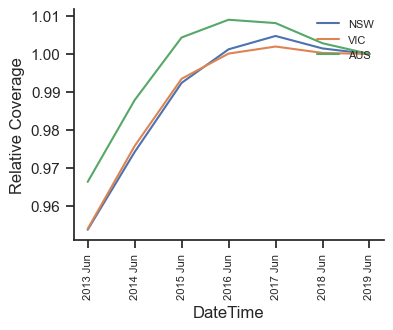

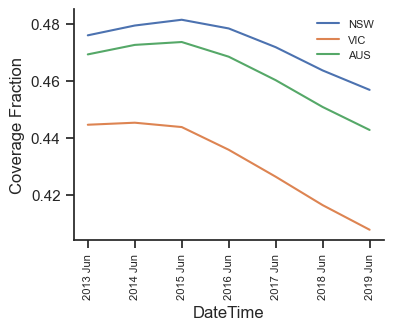

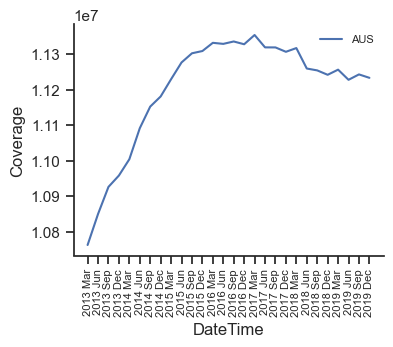

In [9]:
"""example plots"""

june_relative_query = [{
    'MonthEnd': 'Jun',
    'State': state,
} for state in ['NSW', 'VIC', 'AUS']]

aus_relative_query = [{
    'State': state,
} for state in ['AUS']]

plot_var_change(total_cov_df, june_relative_query, y_var=['cov_total', 'Coverage'], norm='relative',)
plot_var_change(total_cov_df, june_relative_query, y_var=['cov_total', 'Coverage'], norm='population')
plot_var_change(total_cov_df, aus_relative_query, y_var=['cov_total', 'Coverage'],)


In [10]:
"""taking a look at the evolving population demographics
"""

age_sum = (coverage_df['AgeCohort HT']
    .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1]')
    .set_index(['Year', 'MonthEnd', 'State'])[['Gender', 'Age', 'InsuredPersons', 'Episodes', 'Days']]
)

merged_dfs = [age_sum, pop_sum]

total_pop_df = functools.reduce(lambda l, r: pd.merge(l, r, left_index=True, right_index=True), merged_dfs).reset_index()

aus_pop_df = total_pop_df.groupby(['Year', 'MonthEnd', 'Gender', 'Age']).sum().reset_index()
aus_pop_df['State'] = 'AUS'

total_pop_df = pd.concat((total_pop_df, aus_pop_df))
total_pop_df['MonthEnd'] = pd.Categorical(total_pop_df['MonthEnd'], categories=CFG.months, ordered=True)
total_pop_df = total_pop_df.sort_values(by=['Year', 'MonthEnd', 'Gender', 'Age'], ignore_index=True)

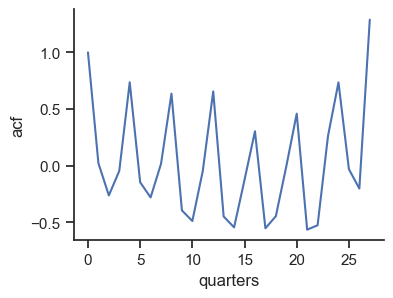

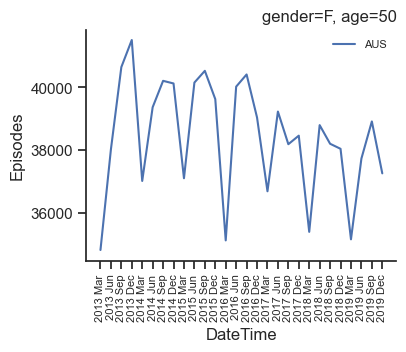

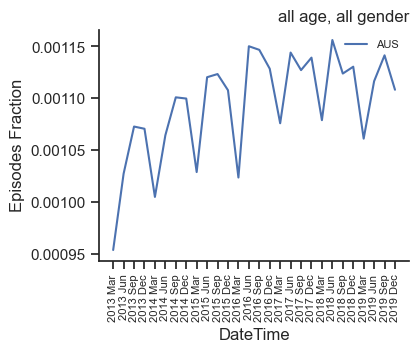

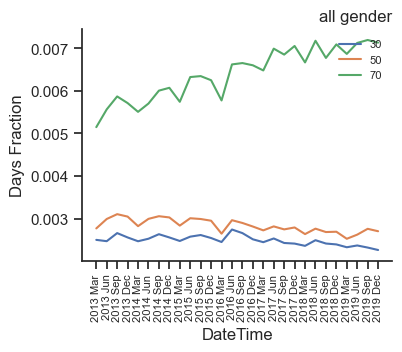

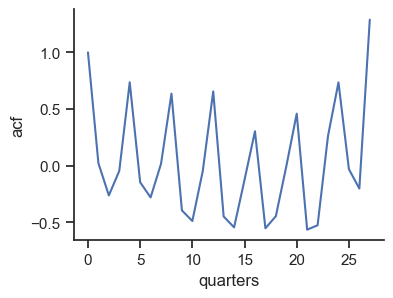

In [12]:
"""look at episodes+days over time
clearly we see a seasonal pattern, where episodes/days peak during the winter. we can check this by looking at
its autocorrelation
"""

def plot_acf(df):
    n = len(df)
    df_var = np.var(df)
    df_ = df - np.mean(df)
    acf = np.correlate(df_, df_, mode='full')[-n:]
    
    assert len(acf) == len(np.arange(n, 0, -1))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(acf/(df_var * np.arange(n, 0, -1)))
    
    ax1.set_xlabel('quarters')
    ax1.set_ylabel('acf')
    
    plt.show()
    
    return

age_relative_query = [{
    'State': state,
    'Age': age
} for state in ['AUS'] for age in [30, 50, 70]]

plot_var_change(total_pop_df.query("Gender == 'F' & Age == 50"), aus_relative_query, y_var=['Episodes', 'Episodes'], title="gender=F, age=50")

plot_var_change(total_pop_df.query("State == 'AUS'").groupby(['Year', 'MonthEnd', 'State']).sum().reset_index(), 
        aus_relative_query, y_var=['Episodes', 'Episodes'], norm='population', title='all age, all gender')

plot_var_change(total_pop_df.query("State == 'AUS'").groupby(['Year', 'MonthEnd', 'State', 'Age']).sum().reset_index(), 
        age_relative_query, y_var=['Days', 'Days'], norm='population', c_var='Age', title='all gender')

#check autocorrelation of first query gender=F, age=50, australia, estimated via en.wikipedia.org/wiki/Autocorrelation

check_acf = clean_extract(total_pop_df.query("Gender == 'F' & Age == 50"), aus_relative_query[0])['Episodes']

plot_acf(check_acf)

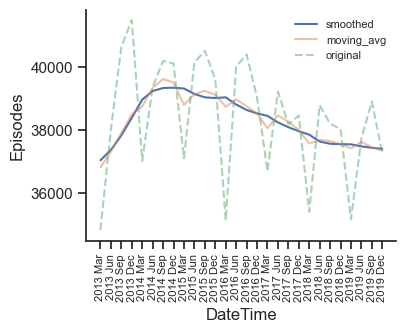

In [13]:
"""from previous, we see acf periodicity of ~4 quarters
let's do a one-year smoothing window to average out the seasonal effect. we can use a simple moving mean,
savitzky-golay filter or just import a scipy library that does this.
use a kernel of ones with length corresponding to 4 quarters on each end and convolve

use the same check_acf query as previous
"""
def moving_mean(x, w = 5):
    """pad x by constants"""
    x_ = np.pad(x, (w//2, w//2), mode='edge')
    kernel = np.ones(w)
    
    return np.convolve(x_, kernel, 'valid')/w


def plot_no_season(df, c_var='Episodes', w=9):
    df_ = pd.DataFrame()
    df_['DateTime'] = df.apply(lambda row: f"{row['Year']} {row['MonthEnd']}", axis=1)
    df_['y']= moving_mean(df[c_var], w)
    df_['y_smoothed'] = savgol_filter(df_['y'], w, 2, mode='nearest')
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.plot(df_['DateTime'], df_['y_smoothed'], label='smoothed')
    ax1.plot(df_['DateTime'], df_['y'], label='moving_avg', alpha=0.5)
    ax1.plot(df_['DateTime'], df[c_var], label='original', ls='dashed', alpha=0.5)
    
    ax1.legend(loc=1, framealpha=0., fontsize=8)
    
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel(f'{c_var}')
    
    plt.show()
    
    return
    
plot_no_season(clean_extract(total_pop_df.query("Gender == 'F' & Age == 50"), aus_relative_query[0]), c_var='Episodes')

In [14]:
"""with the preliminary tools out of the way. let us utilise the full dataset and look for correlations

to answer a) & b) we will limit ourselves to AUS, age brackets between 0-25, 25-50, 50-75, 75+
import population data from ABS as APRA does not segregate by age.
"""

def preprocess_population(fn = CFG.population):

    quarter_encode = {'Q1':'Mar', 'Q2':'Jun', 'Q3':'Sep', 'Q4':'Dec'}

    df = pd.read_csv(fn)
    df = df.iloc[:,[2,3,6,7]]
    df[["Year", "Quarter"]] = df["TIME_PERIOD: Time Period"].str.split('-', 1, expand=True)

    df.loc[df["AGE: Age"] == "8599: 85 and over", "AGE: Age"] = "A85: 85-90"
    df["Age"] = df.apply(lambda row: int(row["AGE: Age"].split(":")[1].split("-")[0]), axis=1)
    df["Year"] = df['Year'].apply(int)
    
    df["SEX: Sex"] = df.apply(lambda row: row["SEX: Sex"].split(":")[1][1], axis=1)
    df["MonthEnd"] = df.apply(lambda row: quarter_encode[row['Quarter']], axis=1)
    df['MonthEnd'] = pd.Categorical(df['MonthEnd'], categories=CFG.months, ordered=True)

    df["State"] = "AUS"

    df = df.rename(columns={"SEX: Sex":"Gender", "OBS_VALUE":"Population"})
    df = df.drop(["TIME_PERIOD: Time Period", "AGE: Age", "Quarter"], axis=1)
    
    
    column_order = ['Year', 'MonthEnd', 'State', 'Gender', 'Age', 'Population']

    return df[column_order]

coverage_df = ss_to_df(CFG.mem_coverage)
benefits_df = ss_to_df(CFG.mem_benefits)
population_df = preprocess_population()


In [15]:
"""manipulate population data into the necessary 4 groups"""
pop_conds = [
    "Age < 25",
    "Age >= 25 & Age < 50", 
    "Age >= 50 & Age < 75",
    "Age >= 75",
]

pop_labels = [
    "0-25",
    "25-50",
    "50-75",
    "75-99",
]

pop_df = pd.DataFrame()

for idx, query in enumerate(pop_conds):
    tmp_df = population_df.query(query).groupby(['Year', 'MonthEnd', 'State', 'Gender'])['Population'].sum().to_frame()
    tmp_df['AgeBracket'] = f'{pop_labels[idx]}'
    
    pop_df = pd.concat([pop_df, tmp_df])
    
pop_df = pop_df.reset_index().sort_values(["Year", "MonthEnd", "Gender", 'AgeBracket'], ignore_index=True)
#pop_df = pop_df.set_index(['Year', 'MonthEnd', 'State', 'Gender', 'AgeBracket'])['Population'].unstack().reset_index()

pop_df.head()

,Year,MonthEnd,State,Gender,Population,AgeBracket
0,2013,Mar,AUS,F,3643136,0-25
1,2013,Mar,AUS,F,4057509,25-50
2,2013,Mar,AUS,F,3035144,50-75
3,2013,Mar,AUS,F,841805,75-99
4,2013,Mar,AUS,M,3831190,0-25


In [16]:
age_sum = (coverage_df['AgeCohort HT']
    .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1]')
    .groupby(['Year', 'MonthEnd', 'Gender', 'Age']).sum()[['InsuredPersons', 'Episodes', 'Days', 'OtherHTBenefits', 'MedicalBenefits', 'Fees']]
    .reset_index()
)

age_sum['MonthEnd'] = pd.Categorical(age_sum['MonthEnd'], categories=CFG.months, ordered=True)
cov_df = pd.DataFrame()

for idx, query in enumerate(pop_conds):
    tmp_df = age_sum.query(query).groupby(['Year', 'MonthEnd', 'Gender']).sum()[['InsuredPersons', 'Episodes', 'Days', 'OtherHTBenefits', 'MedicalBenefits', 'Fees']]
    tmp_df['AgeBracket'] = f'{pop_labels[idx]}'
    
    cov_df = pd.concat([cov_df, tmp_df])
    
cov_df['State'] = 'AUS'
cov_df = cov_df.reset_index().sort_values(["Year", "MonthEnd", "Gender", 'AgeBracket'], ignore_index=True)
#cov_df = cov_df.set_index(['Year', 'MonthEnd', 'State', 'Gender', 'AgeBracket'])['Population'].unstack().reset_index()

cov_df.head()

,Year,MonthEnd,Gender,InsuredPersons,Episodes,Days,OtherHTBenefits,MedicalBenefits,Fees,AgeBracket,State
0,2013,Mar,F,1537739.0,42549,104053,7.510298e+07,1.428081e+07,1.077797e+08,0-25,AUS
1,2013,Mar,F,1903443.0,132338,350878,2.965632e+08,7.344538e+07,4.482265e+08,25-50,AUS
2,2013,Mar,F,1723499.0,213017,510883,4.265536e+08,1.046550e+08,6.954752e+08,50-75,AUS
3,2013,Mar,F,373907.0,92524,417211,2.691390e+08,4.792560e+07,3.788473e+08,75-99,AUS
4,2013,Mar,M,1601870.0,39910,87351,6.741241e+07,1.418856e+07,9.967323e+07,0-25,AUS


In [17]:
all_df = pd.merge(pop_df, cov_df).reset_index(drop=True)

all_age_df = all_df.groupby(['Year', 'MonthEnd', 'Gender', 'State']).sum().reset_index()
all_age_df['AgeBracket'] = 'All'

all_df = pd.concat((all_df, all_age_df))
all_df = all_df.sort_values(by=['Year', 'MonthEnd', 'Gender', 'AgeBracket'], ignore_index=True)

all_df['TotalBenefits'] = all_df[['OtherHTBenefits', 'MedicalBenefits']].sum(axis=1)
all_df['DayEpRatio'] = all_df['Days']/all_df['Episodes']

all_df

,Year,MonthEnd,State,Gender,Population,AgeBracket,InsuredPersons,Episodes,Days,OtherHTBenefits,MedicalBenefits,Fees,TotalBenefits,DayEpRatio
0,2013,Mar,AUS,F,3643136,0-25,1537739.0,42549,104053,7.510298e+07,1.428081e+07,1.077797e+08,8.938379e+07,2.445486
1,2013,Mar,AUS,F,4057509,25-50,1903443.0,132338,350878,2.965632e+08,7.344538e+07,4.482265e+08,3.700085e+08,2.651378
2,2013,Mar,AUS,F,3035144,50-75,1723499.0,213017,510883,4.265536e+08,1.046550e+08,6.954752e+08,5.312086e+08,2.398320
3,2013,Mar,AUS,F,841805,75-99,373907.0,92524,417211,2.691390e+08,4.792560e+07,3.788473e+08,3.170645e+08,4.509219
4,2013,Mar,AUS,F,11577594,All,5538588.0,480428,1383025,1.067359e+09,2.403068e+08,1.630329e+09,1.307665e+09,2.878735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2019,Dec,AUS,M,4095772,0-25,1613171.0,47918,97324,8.846838e+07,1.860033e+07,1.337468e+08,1.070687e+08,2.031053
276,2019,Dec,AUS,M,4428082,25-50,1702232.0,67583,143213,1.377746e+08,3.535875e+07,2.317014e+08,1.731334e+08,2.119068
277,2019,Dec,AUS,M,3355036,50-75,1713790.0,250250,552671,6.200383e+08,1.500373e+08,1.013091e+09,7.700756e+08,2.208476
278,2019,Dec,AUS,M,789233,75-99,405016.0,155609,514685,4.522272e+08,8.377233e+07,6.521352e+08,5.359996e+08,3.307553


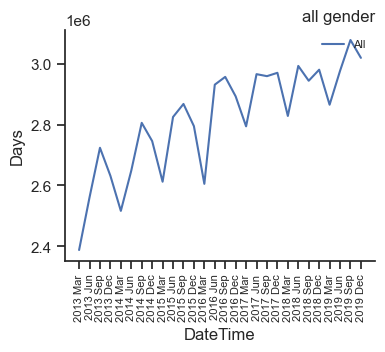

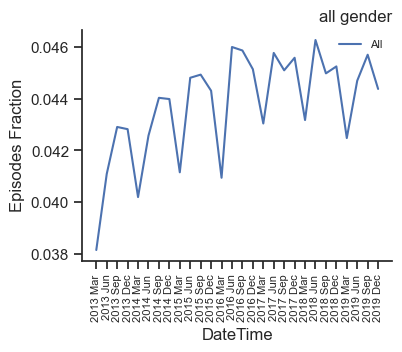

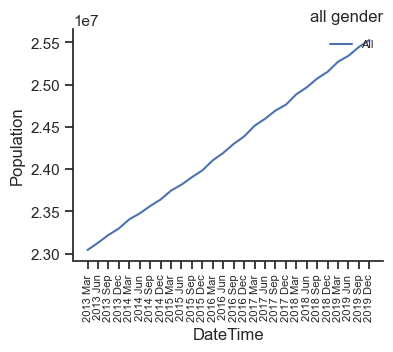

In [18]:
"""more figures on the demographics"""

age_labels = [
    "0-25",
    "25-50",
    "50-75",
    "75-99",
    "All",
]

age_relative_query = [{
    'State': state,
    'AgeBracket': age
} for state in ['AUS'] for age in age_labels[-1:]]


plot_var_change(all_df.groupby(['Year', 'MonthEnd', 'State', 'AgeBracket']).sum().reset_index(), 
        age_relative_query, y_var=['Days', 'Days'], c_var='AgeBracket', title='all gender')

plot_var_change(all_df.groupby(['Year', 'MonthEnd', 'State', 'AgeBracket']).sum().reset_index(), 
        age_relative_query, y_var=['Episodes', 'Episodes'], norm='population', c_var='AgeBracket', title='all gender')

plot_var_change(all_df.groupby(['Year', 'MonthEnd', 'State', 'AgeBracket']).sum().reset_index(), 
        age_relative_query, y_var=['Population', 'Population'], c_var='AgeBracket', title='all gender')


In [19]:
"""group gender, pivot table, incredibly nasty with so many columns"""

# all_pivot_df = (all_df.groupby(['Year', 'MonthEnd', 'State', 'AgeBracket']).sum().reset_index()
#     .set_index(['Year', 'MonthEnd', 'State', 'AgeBracket']).unstack().reset_index()
# )

all_pivot_df = (all_df.groupby(['Year', 'MonthEnd', 'State', 'AgeBracket']).agg({"Population": 'sum',
                                                                                 "InsuredPersons": 'sum',
                                                                                 'Episodes':'sum',
                                                                                 'Days':'sum',
                                                                                 'OtherHTBenefits':'sum',
                                                                                 'MedicalBenefits':'sum',
                                                                                 'Fees':'sum',
                                                                                 'TotalBenefits':'sum',
                                                                                 'DayEpRatio':'mean',})                
    .reset_index().set_index(['Year', 'MonthEnd', 'State', 'AgeBracket']).unstack().reset_index()
)

all_pivot_df.head()



Year MonthEnd State Population                                      InsuredPersons             ... TotalBenefits                                            \
AgeBracket                            0-25    25-50    50-75    75-99       All           0-25      25-50  ...          0-25         25-50         50-75         75-99   
0           2013      Mar   AUS    7474326  8104213  6001580  1462885  23043004      3139609.0  3621573.0  ...  1.709848e+08  4.985261e+08  1.061095e+09  5.988415e+08   
1           2013      Jun   AUS    7489910  8128289  6038605  1471325  23128129      3159726.0  3663313.0  ...  1.745467e+08  5.329962e+08  1.142090e+09  6.569334e+08   
2           2013      Sep   AUS    7516441  8152215  6072169  1479406  23220231      3185294.0  3684516.0  ...  1.928965e+08  5.680038e+08  1.205883e+09  7.122144e+08   
3           2013      Dec   AUS    7527474  8173131  6107248  1489924  23297777      3186479.0  3682053.0  ...  1.896409e+08  5.651595e+08  1.228800e+09  6.991031e+08   
4           2014      Mar   AUS    7561180  8201857  6141632  1501524  23406193      3197373.0  3689875.0  ...  1.780078e+08  5.257824e+08  1.147007e+09  6.627793e+08   

                         DayEpRatio                                          
AgeBracket           All       0-25     25-50     50-75     75-99       All  
0           2.329447e+09   2.317093  2.337145  2.339322  4.004351  2.700396  
1           2.506567e+09   2.346986  2.260223  2.318035  4.029135  2.680061  
2           2.678998e+09   2.323085  2.274770  2.330629  4.168156  2.718088  
3           2.682704e+09   2.198667  2.213927  2.285628  3.951945  2.622551  
4           2.513576e+09   2.275513  2.289038  2.310956  3.918026  2.661346  

[5 rows x 48 columns]

In [20]:
age_relative_query = [{
    'State': state,
    'AgeBracket': age
} for state in ['AUS'] for age in age_labels[-1:]]

all_pivot_df.head()

Year MonthEnd State Population                                      InsuredPersons             ... TotalBenefits                                            \
AgeBracket                            0-25    25-50    50-75    75-99       All           0-25      25-50  ...          0-25         25-50         50-75         75-99   
0           2013      Mar   AUS    7474326  8104213  6001580  1462885  23043004      3139609.0  3621573.0  ...  1.709848e+08  4.985261e+08  1.061095e+09  5.988415e+08   
1           2013      Jun   AUS    7489910  8128289  6038605  1471325  23128129      3159726.0  3663313.0  ...  1.745467e+08  5.329962e+08  1.142090e+09  6.569334e+08   
2           2013      Sep   AUS    7516441  8152215  6072169  1479406  23220231      3185294.0  3684516.0  ...  1.928965e+08  5.680038e+08  1.205883e+09  7.122144e+08   
3           2013      Dec   AUS    7527474  8173131  6107248  1489924  23297777      3186479.0  3682053.0  ...  1.896409e+08  5.651595e+08  1.228800e+09  6.991031e+08   
4           2014      Mar   AUS    7561180  8201857  6141632  1501524  23406193      3197373.0  3689875.0  ...  1.780078e+08  5.257824e+08  1.147007e+09  6.627793e+08   

                         DayEpRatio                                          
AgeBracket           All       0-25     25-50     50-75     75-99       All  
0           2.329447e+09   2.317093  2.337145  2.339322  4.004351  2.700396  
1           2.506567e+09   2.346986  2.260223  2.318035  4.029135  2.680061  
2           2.678998e+09   2.323085  2.274770  2.330629  4.168156  2.718088  
3           2.682704e+09   2.198667  2.213927  2.285628  3.951945  2.622551  
4           2.513576e+09   2.275513  2.289038  2.310956  3.918026  2.661346  

[5 rows x 48 columns]

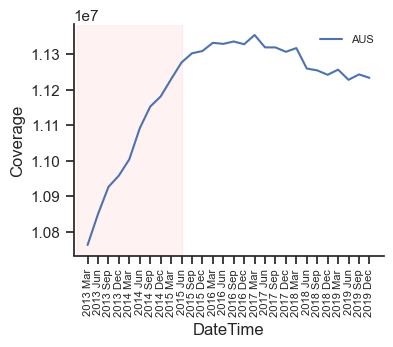

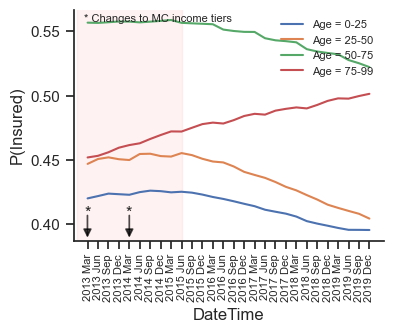

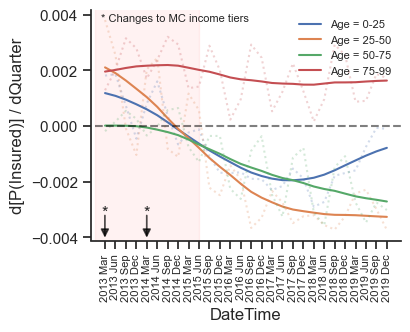

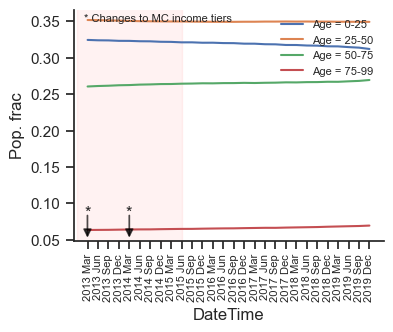

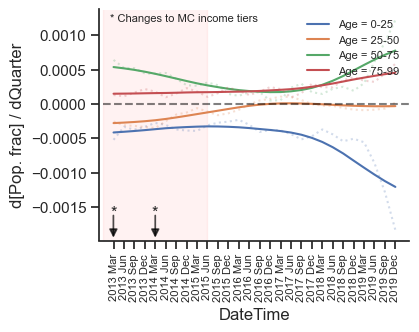

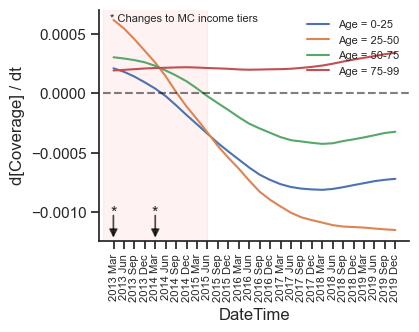

In [21]:
"""answering first question. let's take a look at the fraction of insured persons in each age bracket"""

def plot_fraction(df, y_var=['Population', 'Population'], norm=None, shade=True, save='output', arrow=True, all_=False, w=None, stat=False, title=""):

    age_labels_ = [
        "0-25",
        "25-50",
        "50-75",
        "75-99",
    ]
    
    if all_ == True:
        age_labels_ = ['All']
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    df_ = df.copy()
    df_['DateTime'] = df_.apply(lambda row: f"{row[0]} {row[1]}", axis=1)
    
    min_date = np.where(df_['DateTime'] == CFG.year_min_lim)[0][0]
    max_date = np.where(df_['DateTime'] == CFG.year_max_lim)[0][0]
        
    for idx, i in enumerate(age_labels_):
        if norm in df_.columns.levels[0]:
            df_norm = df_[norm]['All']
        elif norm == 'one':
            df_norm = 1
        else:
            df_norm = df_['Population'][i]
        
        if w:
            df_['y'] = moving_mean((df_[y_var[0]][i]/df_norm), w)
            df_['y_plot'] = savgol_filter(df_['y'], w, 1, mode='nearest')
            
        else:    
            df_['y_plot'] = df_[y_var[0]][i]/df_norm
            
        ax1.plot(df_['DateTime'], (df_['y_plot']), label=f'Age = {i}', color=CFG.col_array[idx])
        
        if w:
            ax1.plot(df_['DateTime'], (df_[y_var[0]][i]/df_norm), color=CFG.col_array[idx], ls='dotted', alpha=0.35)
    
        if stat:
            print(f"Mean between the specified dates: {df_['y_plot'].iloc[min_date:max_date+1].mean()}")
            print(f"The {i} group finds a {df_['y_plot'].iloc[max_date]/df_['y_plot'].iloc[min_date]} growth in {y_var[1]}")
            print("")
    
    y_min, y_max = ax1.get_ylim()
    x_min, x_max = ax1.get_xlim()
    
    if title:
        ax1.set_title(title, fontsize=12, loc='right')
        
    if shade:
        ax1.fill_between([-1, min_date], y_min*0.95, y_max*1.05, color='red', alpha=0.05)
     
    if arrow:
        ax1.annotate("",
            xy=(0.045, 0.0), xycoords='axes fraction',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="-|>",
                            color="#000000",
                            lw=1.25,
                            alpha=0.7),
            )
        ax1.annotate("*", xy=(0.034, 0.1), xycoords='axes fraction',)
        ax1.annotate("",
            xy=(0.18, 0.0), xycoords='axes fraction',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="-|>",
                            color="#000000",
                            lw=1.25,
                            alpha=0.7),
            )
        ax1.annotate("*", xy=(0.168, 0.1), xycoords='axes fraction',)
        ax1.annotate("* Changes to MC income tiers", xy=(0.034, 0.95), xycoords='axes fraction', fontsize=8,)
    
    ax1.legend(loc=1, framealpha=0., fontsize=8)
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel(y_var[1])
    
    if save:
        plt.savefig(f"{save}/frac_{y_var[0]}.png", dpi=300, bbox_inches = "tight")
        
    plt.show()

    return

def plot_deriv_fraction(df, y_var=['Population', 'Population'], w=9, norm=None, shade=True, title="", save='output', stat=False, arrow=True):
    """smooth seasonal aspect via a moving average + savgol filter"""
    
    age_labels_ = [
        "0-25",
        "25-50",
        "50-75",
        "75-99",
    ]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    df_ = df.copy()
    df_['DateTime'] = df_.apply(lambda row: f"{row[0]} {row[1]}", axis=1)
    
    min_date = np.where(df_['DateTime'] == CFG.year_min_lim)[0][0]
    max_date = np.where(df_['DateTime'] == CFG.year_max_lim)[0][0]

    for idx, i in enumerate(age_labels_):
        if norm == 'population':
            df_norm = df_['Population']['All']
        elif norm == 'one':
            df_norm = 1
        else:
            df_norm = df_['Population'][i]
        
        df_['tmp_grad'] = np.gradient((df_[y_var[0]][i]/df_norm))
        df_['y'] = moving_mean(df_['tmp_grad'], w)
        df_['smoothed'] = savgol_filter(df_['y'], w, 1, mode='nearest')
        
        ax1.plot(df_['DateTime'], df_['smoothed'], label=f'Age = {i}', color=CFG.col_array[idx])
        ax1.plot(df_['DateTime'], np.gradient((df_[y_var[0]][i]/df_norm)), color=CFG.col_array[idx], ls='dotted', alpha=0.25)
        
        if stat:
            print(f"Mean between the specified dates: {df_['smoothed'].iloc[min_date:max_date+1].mean()}")
            print(f"The {i} group finds a {df_['smoothed'].iloc[max_date]/df_['smoothed'].iloc[min_date]} growth in {y_var[1]}")
            print("")
        
    if title:
        ax1.set_title(title, fontsize=8, loc='right')
        
    y_min, y_max = ax1.get_ylim()
    x_min, x_max = ax1.get_xlim()
        
    if shade:
        ax1.fill_between([-1, min_date], y_min*1.05, y_max*1.05, color='red', alpha=0.05)
        
    
    ax1.plot([-1, len(df_['DateTime'])+1], [0, 0], color='#000000', alpha=0.5, ls='dashed')
    
    if arrow:
        ax1.annotate("",
            xy=(0.045, 0.0), xycoords='axes fraction',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="-|>",
                            color="#000000",
                            lw=1.25,
                            alpha=0.7),
            )
        ax1.annotate("*", xy=(0.034, 0.1), xycoords='axes fraction',)
        ax1.annotate("",
            xy=(0.18, 0.0), xycoords='axes fraction',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="-|>",
                            color="#000000",
                            lw=1.25,
                            alpha=0.7), 
            )
        ax1.annotate("*", xy=(0.168, 0.1), xycoords='axes fraction',)
        ax1.annotate("* Changes to MC income tiers", xy=(0.034, 0.95), xycoords='axes fraction', fontsize=8,)
    
    legend = ax1.legend(loc=1, framealpha=0., fontsize=8)
#     legend.set_title('AgeBracket', prop={'size':8})
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel(y_var[1])
    
    if save:
        plt.savefig(f"{save}/deriv_{y_var[0]}.png", dpi=300, bbox_inches = "tight")

    plt.show()
        
    return

def plot_cderiv_fraction(df, w=9, shade=True, title="", save='output'):
    """smooth seasonal aspect via a moving average + savgol filter"""
    
    age_labels_ = [
        "0-25",
        "25-50",
        "50-75",
        "75-99",
    ]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    df_ = df.copy()
    df_['DateTime'] = df_.apply(lambda row: f"{row[0]} {row[1]}", axis=1)

    for idx, i in enumerate(age_labels_):

        df_pop_norm = df_['Population']['All']
        df_y_norm = df_['Population'][i]
        
        #population dP/dt
        df_['pop_tmp_grad'] = np.gradient((df_['Population'][i]/df_pop_norm))
        df_['pop_y'] = moving_mean(df_['pop_tmp_grad'], w)
        df_['pop_smoothed'] = savgol_filter(df_['pop_y'], w, 1, mode='nearest')
        
        #insured dI/dt
        df_['in_tmp_grad'] = np.gradient((df_["InsuredPersons"][i]/df_y_norm))
        df_['in_y'] = moving_mean(df_['in_tmp_grad'], w)
        df_['in_smoothed'] = savgol_filter(df_['in_y'], w, 1, mode='nearest')
        
        df_['pop_frac'] = df_["Population"][i]/df_pop_norm
        df_['in_frac'] = df_["InsuredPersons"][i]/df_y_norm
        
        df_['c_contrib'] = df_['pop_smoothed'] * df_['in_frac'] + df_['in_smoothed'] * df_['pop_frac']
        
        ax1.plot(df_['DateTime'], df_['c_contrib'], label=f'Age = {i}', color=CFG.col_array[idx])
        #ax1.plot(df_['DateTime'], np.gradient((df_[y_var[0]][i]/df_norm)), color=CFG.col_array[idx], ls='dotted', alpha=0.25)
        
    if title:
        ax1.set_title(title, fontsize=8, loc='right')
        
    y_min, y_max = ax1.get_ylim()
    x_min, x_max = ax1.get_xlim()
        
    if shade:
        idx = np.where(df_['DateTime'] == CFG.year_min_lim)[0][0]
        ax1.fill_between([-1, idx], y_min*1.05, y_max*1.05, color='red', alpha=0.05)
        
    
    ax1.plot([-1, len(df_['DateTime'])+1], [0, 0], color='#000000', alpha=0.5, ls='dashed')
    

    ax1.annotate("",
        xy=(0.045, 0.0), xycoords='axes fraction',
        xytext=(0, 20), textcoords='offset points',
        arrowprops=dict(arrowstyle="-|>",
                        color="#000000",
                        lw=1.25,
                        alpha=0.7),
        )
    ax1.annotate("*", xy=(0.034, 0.1), xycoords='axes fraction',)
    ax1.annotate("",
        xy=(0.18, 0.0), xycoords='axes fraction',
        xytext=(0, 20), textcoords='offset points',
        arrowprops=dict(arrowstyle="-|>",
                        color="#000000",
                        lw=1.25,
                        alpha=0.7), 
        )
    ax1.annotate("*", xy=(0.168, 0.1), xycoords='axes fraction',)
    ax1.annotate("* Changes to MC income tiers", xy=(0.034, 0.95), xycoords='axes fraction', fontsize=8,)
    
    legend = ax1.legend(loc=1, framealpha=0., fontsize=8)
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel('d[Coverage] / dt')
    
    if save:
        plt.savefig(f"{save}/c_deriv.png", dpi=300, bbox_inches = "tight")

    plt.show()
        
    return

plot_var_change(total_cov_df, aus_relative_query, y_var=['cov_total', 'Coverage'], norm='Population', shade=True)

plot_fraction(all_pivot_df, y_var=["InsuredPersons","P(Insured)"])
plot_deriv_fraction(all_pivot_df, y_var=["InsuredPersons","d[P(Insured)] / dQuarter"])

plot_fraction(all_pivot_df, y_var=["Population","Pop. frac"], norm='Population')

plot_deriv_fraction(all_pivot_df, y_var=["Population","d[Pop. frac] / dQuarter"], norm='population')

plot_cderiv_fraction(all_pivot_df)

### Answering A) What could be causing a decrease in hospital coverage uptake since June 2015?
<a id='ans_a'></a>

* (Referencing plots generated above)

* Between June 2015 to June 2019, i.e pre-COVID, we see a marked decrease of all age groups <75 years old in purchasing PHI. This is best represented in the second figure, where we see that the rate of change of insured fraction decreasing as a function of time. 

* As the overall coverage is given by,

$$C = \dfrac{\sum^{\mathrm{AgeBrackets}}_{i} \mathrm{Pop}_{i} \cdot P(\mathrm{Insured}_{i})}{\sum^{\mathrm{AgeBrackets}}_{i} \mathrm{Pop}_{i}}$$

* where $\mathrm{Pop}_{i}$ is the population of the $i$th age bracket, and $P(\mathrm{Insured}_{i})$ is the probability of a person in the $i$th age bracket having PHI, we note that each of these terms are dependent on time (our quarters). Thus the coverage over time is given by,

$$ \dfrac{dC}{dt} = \sum^{\mathrm{AgeBrackets}}_{i} \dfrac{d\mathcal{P}_{i}}{dt} P(\mathrm{Insured}_{i}) + \dfrac{P(\mathrm{Insured}_{i})}{dt}\mathcal{P}_{i}$$,

* where $\mathcal{P}_{i} = \frac{\mathrm{Pop}_{i}}{\sum^{\mathrm{AgeBrackets}}_{i} \mathrm{Pop}_{i}}$ or our population fraction. As both $\mathcal{P}_{i}$ and $P(\mathrm{Insured}_{i})$ are proportions bounded between $[0,1]$, and $|\frac{d\mathcal{P}_{i}}{dt}| << |\frac{P(\mathrm{Insured}_{i})}{dt}|$, for all $i$, we can infer that the primary cause of the rate of change in coverage fraction is primarily due to the decreasing uptake of PHI in various age brackets. We summarize by:

    1. The biggest contributors to the decreasing coverage fraction in age brackets are (in order of largest to smallest): 25-50, 0-25, 50-75 and 75+, where the 75+ group is the only bracket to provide a positive contribution to coverage fraction from 2015 onwards. 
    2. While it looks like the 50-75 group had a bigger drop in rate of PHI uptake compared to the 0-25 group, the 0-25 group still had a greater *negative contribution* to the overall coverage fraction because of its shrinking population. Speculatively, this may be due to a declining birthrate thus we have less people taking out family policies to insure people in the 0-25 group. We can get a *rough idea* of this by comparing the number of family policies, normalized by population across time.
    3. We speculate the reasons why the fraction of uptake is decreasing may be attributed to the changes in the Medicare Levy Surcharge where the threshold was increased once in 2012 and once again in 2013. This may have an immediate impact in decentivizing purchasing PHI when one can rely on public infrastructure instead.


In [22]:
"""checking rate of family policies being taken
"""

f_pol = [
    "Family",
    "Single parent"
]

family_hto_sum = (coverage_df['HTOnly']
    .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1] & Coverage == "Policies"')
    .groupby(['Year', 'MonthEnd', 'State', 'PolicyCategory'])
    .value.sum().astype(int).to_frame()
)

family_htgt_sum = (coverage_df['HTandGTCombined']
    .query('Year >= @CFG.years[0] & Year <= @CFG.years[-1] & Coverage == "Policies"')
    .groupby(['Year', 'MonthEnd', 'State', 'PolicyCategory'])
    .value.sum().astype(int).to_frame()
)

merged_family_dfs = [family_hto_sum, family_htgt_sum, pop_sum]

family_df = functools.reduce(lambda l, r: pd.merge(l, r, left_index=True, right_index=True, suffixes=["_HTO", "_HTGT"]), merged_family_dfs).reset_index()
family_df['cov_total'] = family_df[["value_HTO", "value_HTGT"]].sum(axis=1)

aus_family_df = family_df.groupby(['Year', 'MonthEnd', 'PolicyCategory']).sum().reset_index()
aus_family_df['State'] = 'AUS'

family_df = pd.concat((family_df, aus_family_df))
family_df['MonthEnd'] = pd.Categorical(family_df['MonthEnd'], categories=CFG.months, ordered=True)
family_df = family_df.sort_values(by=['Year','MonthEnd'], ignore_index=True)

family_df.head()


,Year,MonthEnd,State,PolicyCategory,value_HTO,value_HTGT,Population,cov_total
0,2013,Mar,ACT,2+ persons no adults,0,65,382082,65
1,2013,Mar,ACT,3+ adults,0,5,382082,5
2,2013,Mar,ACT,Couple,9,20598,382082,20607
3,2013,Mar,ACT,Family,13,28132,382082,28145
4,2013,Mar,ACT,Single,25,52635,382082,52660


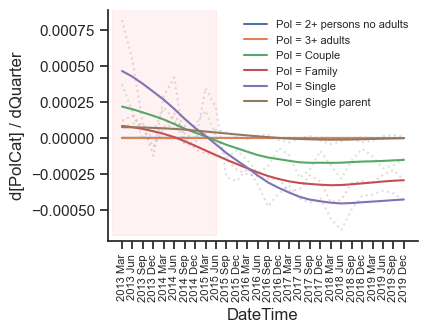

In [23]:
def plot_var_deriv_change(df, query, y_var=['Population', 'Population'], w=9, norm=None, shade=True, title=""):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    for idx, i in enumerate(query):
        df_ = clean_extract(df, i)

        assert (df_.groupby(['Year', 'MonthEnd']).size() > 1).any() == False, 'you have multiple y-values for at least 1 x-value. adjust your input df or your query'
        
        df_['DateTime'] = df_.apply(lambda row: f"{row['Year']} {row['MonthEnd']}", axis=1)
        
        if norm == 'population':
            df_norm = df_['Population']
        else:
            df_norm = 1

        df_['tmp_grad'] = np.gradient((df_[y_var[0]]/df_norm))
        df_['y'] = moving_mean(df_['tmp_grad'], w)
        df_['smoothed'] = savgol_filter(df_['y'], w, 1, mode='nearest')
        
        ax1.plot(df_['DateTime'], df_['smoothed'], label=f'Pol = {i["PolicyCategory"]}', color=CFG.col_array[idx])
        ax1.plot(df_['DateTime'], np.gradient((df_[y_var[0]]/df_norm)), color=CFG.col_array[idx], ls='dotted', alpha=0.25)
        
    y_min, y_max = ax1.get_ylim()
    x_min, x_max = ax1.get_xlim()
        
    if title:
        ax1.set_title(title, fontsize=12, loc='right')
        
    if shade:
        idx = np.where(df_['DateTime'] == CFG.year_min_lim)[0][0]
        ax1.fill_between([-1, idx], y_min*0.95, y_max*1.05, color='red', alpha=0.05)
    
    ax1.legend(loc=1, framealpha=0., fontsize=8)
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    
    ax1.set_xlabel('DateTime')
    ax1.set_ylabel(y_var[1])
    
    plt.show()
    
    return

aus_relative_query = [{
    'State': state,
} for state in ['AUS']]

fam_query = [{
    'State': state,
    'PolicyCategory': fcat,
} for state in ['AUS'] for fcat in family_df['PolicyCategory'].unique()]

# plot_var_change(family_df.query("PolicyCategory == @f_pol").groupby(['Year', 'MonthEnd', 'State'])
#     .sum().reset_index(), 
#     aus_relative_query, y_var=['cov_total', 'Family'], norm='population', shade=True)

# plot_var_change(family_df.query("PolicyCategory != @f_pol").groupby(['Year', 'MonthEnd', 'State'])
#     .sum().reset_index(), 
#     aus_relative_query, y_var=['cov_total', '!Family'], norm='population', shade=True)

plot_var_deriv_change(family_df, 
    fam_query, y_var=['cov_total', 'd[PolCat] / dQuarter'], norm='population', shade=True)


As the only policies that bring children into the 0-25 age bracket are the single parent or the family categories - and both of these are zero/negative, we can say that the 0-25 demographic can only decrease.

Mean between the specified dates: 3141792112.7007556
The All group finds a 1.180295541492535 growth in TotalBenefits ($)



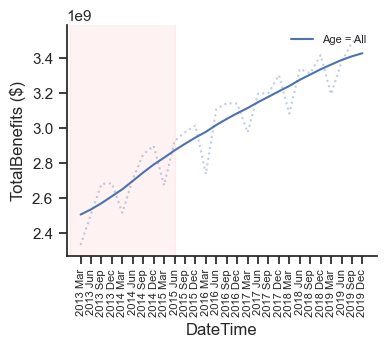

Mean between the specified dates: 207571473.29822075
The 0-25 group finds a 1.1200387607360567 growth in TotalBenefits ($)

Mean between the specified dates: 606271243.7724329
The 25-50 group finds a 1.0719025736674208 growth in TotalBenefits ($)

Mean between the specified dates: 1419858475.109615
The 50-75 group finds a 1.1639421376339587 growth in TotalBenefits ($)

Mean between the specified dates: 908090920.5204866
The 75-99 group finds a 1.3023688633433068 growth in TotalBenefits ($)



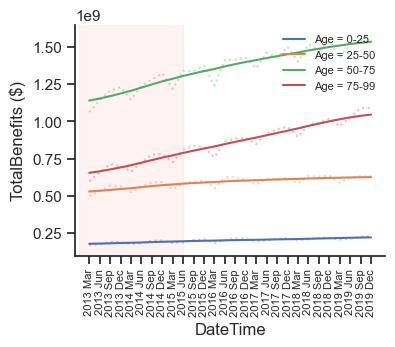

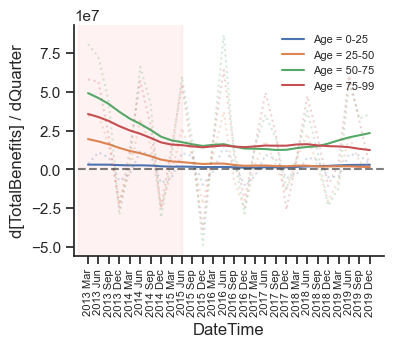

In [24]:
"""now we answer B) using the tables we have defined. the industry wide impacts can be seen in the changes
in episodes or days. where high episodes and low days will maximize profit

most likely while we can still enjoy a NET profitability, it is virtually guaranteed that our profit growth
could have been better if not for the reduced uptake of PHI funneling into the usage of private hospitals.

we will conduct this exercise in the reins of benefits only (otherhospital/medical), as fees are an aspect that a
PH may control individually

all plots below are corrected for seasonal effects
"""

plot_fraction(all_pivot_df, y_var=["TotalBenefits","TotalBenefits ($)"], all_=True, norm='one', arrow=False, w=9, stat=True)
plot_fraction(all_pivot_df, y_var=["TotalBenefits","TotalBenefits ($)"], norm='one', arrow=False, w=9, stat=True)
plot_deriv_fraction(all_pivot_df, y_var=["TotalBenefits","d[TotalBenefits] / dQuarter"], norm='one', arrow=False, w=9)


Mean between the specified dates: 94472.76397966594
The 0-25 group finds a 1.0288777586580817 growth in Episodes

Mean between the specified dates: 218756.29847494556
The 25-50 group finds a 0.9768290177632218 growth in Episodes

Mean between the specified dates: 514076.01815541036
The 50-75 group finds a 1.075115092728916 growth in Episodes

Mean between the specified dates: 265876.74582425563
The 75-99 group finds a 1.228548033510611 growth in Episodes



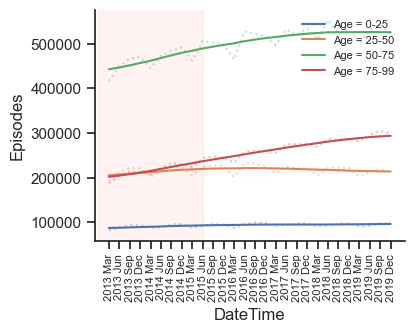

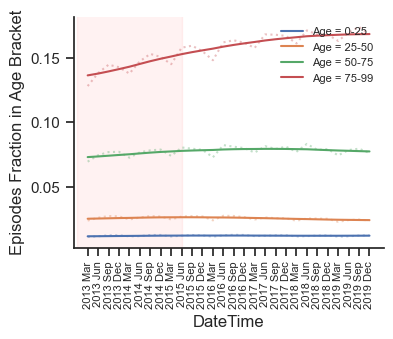

Mean between the specified dates: 0.0864930472319416
The 0-25 group finds a 0.9475958572818243 growth in Episodes Fraction by Total Eps

Mean between the specified dates: 0.20032631156354716
The 25-50 group finds a 0.8998212451093971 growth in Episodes Fraction by Total Eps

Mean between the specified dates: 0.470285041504516
The 50-75 group finds a 0.9906873760560273 growth in Episodes Fraction by Total Eps

Mean between the specified dates: 0.24289559969999536
The 75-99 group finds a 1.1328979754834476 growth in Episodes Fraction by Total Eps



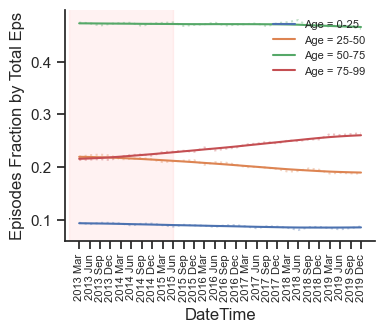

In [25]:
plot_fraction(all_pivot_df, y_var=["Episodes","Episodes"], norm='one', arrow=False, w=9, stat=True)
plot_fraction(all_pivot_df, y_var=["Episodes","Episodes Fraction in Age Bracket"], arrow=False, w=9)
plot_fraction(all_pivot_df, y_var=["Episodes","Episodes Fraction by Total Eps"], norm='Episodes', arrow=False, w=9, stat=True)


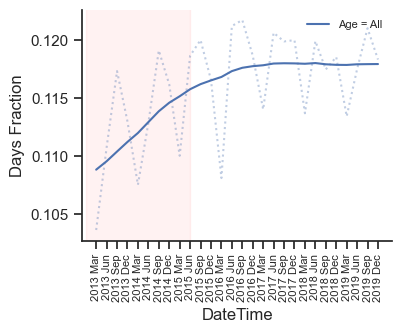

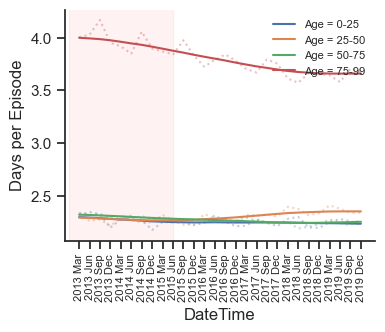

In [26]:
plot_fraction(all_pivot_df, y_var=["Days","Days Fraction"], all_=True, arrow=False, w=9)
plot_fraction(all_pivot_df, y_var=["DayEpRatio","Days per Episode"], norm='one', arrow=False, w=9)

As we can see above, PHs still enjoy growing benefits even when uptake is low. As mentioned, healthy individuals do not go to hospital often. We reasonably expect patient days to follow episodes as the days spent by a patient for a single episode can be approximately given as a Poissonian distribution centred at the mean number of days spent by the global patient population.

The caveat here is if hospital policies changes to encourage discharging early. We actually do see that this is indeed the case, at least for the oldest bracket. We can do a simple verification by fitting a linear relation to the smoothed time series for the 75-99 bracket, and calculating the number of standard deviations away the gradient is from 0. As this is an EDA and I have clearly run out of number of plots I need to present on the dashboard, I will leave the modeling as an exercise for the reader.

### Answering B) In that time period, what is the corresponding impact to industry-wide private hospitals benefits and activity (both episodes & patient days)?
<a id='ans_b'></a>

* From the first plot, the private hospital industry still enjoys an growth of **18%** in the respective benefits in despite the downturn in PHI intake.
* The biggest contributor in the overall benefits are the age brackets (in order): 50-75, 75-99, 25-50, 0-25, where the 50-75 bracket encapsulates a **~constant fraction of 47%** (coincidence) across episodes in a time period. The age bracket to see the largest growth in number of episodes is the 75-99 group, with a growth of **19%** over the time period. The only group to 
    * The combination of being the second largest age bracket in size in conjunction with advanced age has shown that this bracket is the largest in benefits, episodes and days in magnitude.
    * While smallest in population size, the 75-99 age group shows value in matching the growth of benefits per quarter as the largest group (50-75). This impact is mostly from being the only group to have a positive growth in coverage per quarter.

* If we ask the question, what are the hospitals missing out on from the decrease coverage of the <75 age groups. We can look at the quantity (or any other configurations of):

$$ E_{i} = \mathrm{Insured}_{i} \cdot \Big( \dfrac{E_{i}}{\mathrm{Insured}_{i}} \Big)$$

where $E_{i}$ is the Episodes, and $\Big( \dfrac{E_{i}}{\mathrm{Insured}_{i}} \Big)$ is the probability of admittance for an insured person. In principle, this probability should only depend on time and not the size of the group. Thus, **the number of episodes can be assumed to be directly proportional to our insured population**. It naturally follows that **Benefits**, which is proportional to Episodes in an age group (different age groups have different distribution of treatments they usually opt for), would also be **proportional to the population of insured**.

* Knowing this, we look at the two age groups that had suffered large swings in their *growth* of insured populations, the 25-50 and 50-75 age groups and calculate what could have been assuming no drop in growth from Jun 2015.

* Accounting for the loss of growth in the two age groups, the potential benefit is \\$3.47b vs \\$3.38b of our actual benefit value by 2019 Jun.

* This corresponds to a **growth improvement of ~18.5%** in benefits for the private hospital industry. Equivalently, *the approximate impact from the reduction of private health* is losing a potential **2.7%** of our current value.

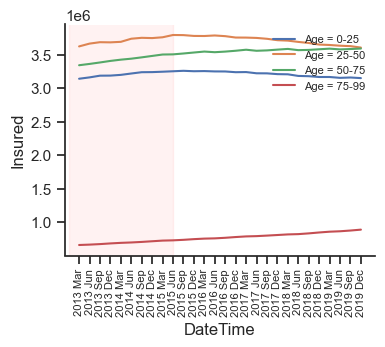

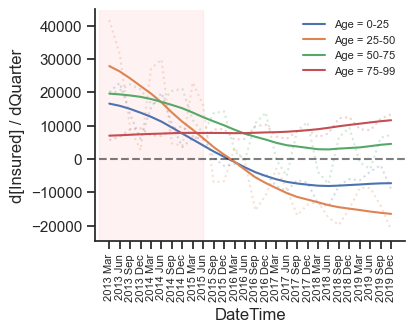

Age25-50: Potential population multiplier 1.0664012160802498
Potential benefits: 665330342.1447716

Age50-75: Potential population multiplier 1.0320501775779178
Potential benefits: 1562054518.8057454

Magnitude of potential benefits: 3466322038.1405168
Potential overall gain from June 2015: 1.1848401757141718
An increase of 1.0266371514046755 over actual benefits


In [27]:
def potential_gain(df, y_var=['InsuredPersons', 'InsuredPersons'], w=9):
    
    age_labels_ = age_labels[:-1]
    
    df_ = df.copy()
    df_['DateTime'] = df_.apply(lambda row: f"{row[0]} {row[1]}", axis=1)
    min_date = np.where(df_['DateTime'] == CFG.year_min_lim)[0][0]
    max_date = np.where(df_['DateTime'] == CFG.year_max_lim)[0][0]
    
    potential_ben = []
    actual_ben = []
    
    for i in age_labels[1:3]:
        df_['tmp_grad'] = np.gradient(df_[y_var[0]][i])
        df_['y'] = moving_mean(df_['tmp_grad'], w)
        df_['smoothed'] = savgol_filter(df_['y'], w, 1, mode='nearest')
        
        actual_change = np.cumsum(df_['smoothed'][min_date:max_date+1]).iloc[-1]
        potential_change = df_['smoothed'][min_date] * (max_date + 1 - min_date)
        
        diff_ = ((potential_change - actual_change) + df_[y_var[0]][i][max_date])/df_[y_var[0]][i][max_date]
        
        print(f"Age{i}: Potential population multiplier {diff_}")
        print(f"Potential benefits: {df_['TotalBenefits'][i][max_date] * diff_}")
        print("")
        
        actual_ben.append(df_['TotalBenefits'][i][max_date])
        potential_ben.append(df_['TotalBenefits'][i][max_date] * diff_)

    start_ben = df_['TotalBenefits'][age_labels_].iloc[min_date].sum()
    real_ben = df_['TotalBenefits'][age_labels_].iloc[max_date].sum()
    wishful_ben = df_['TotalBenefits'][age_labels_].iloc[max_date].sum() - df_['TotalBenefits'][age_labels[1:3]].iloc[max_date].sum() + np.sum(potential_ben)
    
    print(f"Magnitude of potential benefits: {wishful_ben}")
    print(f"Potential overall gain from June 2015: {wishful_ben/start_ben}")
    print(f"An increase of {wishful_ben/real_ben} over actual benefits")
        
    return

plot_fraction(all_pivot_df, y_var=["InsuredPersons","Insured"], norm='one', save=None, arrow=False, stat=False)
plot_deriv_fraction(all_pivot_df, y_var=["InsuredPersons","d[Insured] / dQuarter"], norm='one', save=None, arrow=False)

potential_gain(all_pivot_df)
